# Predict selected data using fine-tuned models

In [1]:
import os
import aiohttp

import pandas as pd
import numpy as np
import torch

import transformers
from transformers import BertModel, BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import (AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification,
                          Trainer, TrainingArguments)
from datasets import load_dataset

from imblearn.over_sampling import RandomOverSampler

import os
os.environ['TRANSFORMERS_CACHE'] = 'data/volume_1/cache_hf'
os.environ['HF_HOME'] = 'data/volume_1/cache_hf'

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: GeForce RTX 2080 Ti


## Load tokenizer and set parameters

In [3]:
from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification

MAX_LENGHT = 512
DATA_DIR = "/home/leonardovida/dev/hist-aware/notebooks/data/labeled-full/split_labeled/merged_split/"

# For tokenizer
checkpoint = "wietsedv/bert-base-dutch-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

## Predict on test

In [4]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [5]:
from transformers import pipeline
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
    
def show_confusion_matrix(confusion_matrix):
    
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')

### Model per type per decade (12 total)

Predicting on test set for 1960s_coal.
Finished prediction on test dataset.
Creating confusion matrix and report.
Confusion matrix
Classification report
Finished. 
 --- 

Predicting on test set for 1970s_coal.
Finished prediction on test dataset.
Creating confusion matrix and report.
Confusion matrix
Classification report
Finished. 
 --- 

Predicting on test set for 1980s_coal.
Finished prediction on test dataset.
Creating confusion matrix and report.
Confusion matrix
Classification report
Finished. 
 --- 

Predicting on test set for 1990s_coal.
Finished prediction on test dataset.
Creating confusion matrix and report.
Confusion matrix
Classification report
Finished. 
 --- 

Predicting on test set for 1960s_oil.
Finished prediction on test dataset.
Creating confusion matrix and report.
Confusion matrix
Classification report
Finished. 
 --- 

Predicting on test set for 1970s_oil.
Finished prediction on test dataset.
Creating confusion matrix and report.
Confusion matrix
Classification r

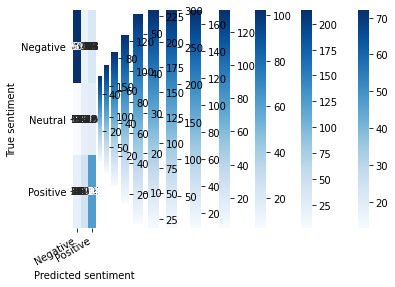

In [8]:
from datasets import load_from_disk

DECADES = ["1960", "1970", "1980", "1990"]
TYPES = ["coal", "oil", "gas"]
reports = []
matrices = []
for TYPE in TYPES:
    for DECADE in DECADES:
        NAME = f"{DECADE}s_{TYPE}"
        DIR_MODEL = f"/home/leonardovida/data/volume_1/delphbert-results/6-finetuning-outputs/model-type-decade/{NAME}"
        
        model = AutoModelForSequenceClassification.from_pretrained(DIR_MODEL, local_files_only=True)
        
        test = load_from_disk(dataset_path = f"{DIR_MODEL}/datasets/test")
        
        text_classification = pipeline(
        "sentiment-analysis",
        model=model,
        tokenizer=tokenizer
        )

        # Predict labels test
        print(f"Predicting on test set for {NAME}.")
        
        preds = []
        for t in test:
            preds.append(text_classification(t["text"]))
            
        print("Finished prediction on test dataset.")
        
        # Cleanup predictions
        y_preds = []
        for x in preds:
            if x[0]["label"] == "LABEL_0":
                y_pred = 0
            if x[0]["label"] == "LABEL_1":
                y_pred = 1
            if x[0]["label"] == "LABEL_2":
                y_pred = 2
            y_preds.append(y_pred)

        # Gather ground truth test
        y_test = test["label"]
        
        print("Creating confusion matrix and report.")
        class_names = ["Negative", "Neutral", "Positive"]
        cm = confusion_matrix(y_test, y_preds)
        df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
        print("Confusion matrix")
        matrices.append(show_confusion_matrix(df_cm))
        print("Classification report")
        reports.append(classification_report(y_test, y_preds, target_names=class_names))

        print("Finished. \n --- \n")

### Model per type across decades

Predicting on test set for coal.
Finished prediction on test dataset.
Creating confusion matrix and report.
Confusion matrix
Classification report
Finished. 
 --- 

Predicting on test set for oil.
Finished prediction on test dataset.
Creating confusion matrix and report.
Confusion matrix
Classification report
Finished. 
 --- 

Predicting on test set for gas.
Finished prediction on test dataset.
Creating confusion matrix and report.
Confusion matrix
Classification report
Finished. 
 --- 



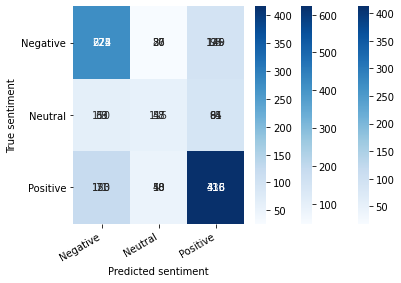

In [7]:
from datasets import load_from_disk

DECADES = ["1960", "1970", "1980", "1990"]
TYPES = ["coal", "oil", "gas"]
reports = []
matrices = []
for TYPE in TYPES:
    NAME = f"{TYPE}"
    DIR_MODEL = f"/home/leonardovida/data/volume_1/delphbert-results/6-finetuning-outputs/model-per-type/{NAME}"

    model = AutoModelForSequenceClassification.from_pretrained(DIR_MODEL, local_files_only=True)

    test = load_from_disk(dataset_path = f"{DIR_MODEL}/datasets/test")

    text_classification = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer
    )

    # Predict labels test
    print(f"Predicting on test set for {NAME}.")

    preds = []
    for t in test:
        preds.append(text_classification(t["text"]))

    print("Finished prediction on test dataset.")

    # Cleanup predictions
    y_preds = []
    for x in preds:
        if x[0]["label"] == "LABEL_0":
            y_pred = 0
        if x[0]["label"] == "LABEL_1":
            y_pred = 1
        if x[0]["label"] == "LABEL_2":
            y_pred = 2
        y_preds.append(y_pred)

    # Gather ground truth test
    y_test = test["label"]

    print("Creating confusion matrix and report.")
    class_names = ["Negative", "Neutral", "Positive"]
    cm = confusion_matrix(y_test, y_preds)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    print("Confusion matrix")
    matrices.append(show_confusion_matrix(df_cm))
    print("Classification report")
    reports.append(classification_report(y_test, y_preds, target_names=class_names))

    print("Finished. \n --- \n")

In [8]:
for r in reports:
    print(r)

              precision    recall  f1-score   support

    Negative       0.67      0.58      0.62       387
     Neutral       0.47      0.32      0.38       148
    Positive       0.69      0.82      0.75       502

    accuracy                           0.66      1037
   macro avg       0.61      0.58      0.58      1037
weighted avg       0.65      0.66      0.65      1037

              precision    recall  f1-score   support

    Negative       0.67      0.73      0.70       851
     Neutral       0.47      0.33      0.39       350
    Positive       0.59      0.63      0.61       534

    accuracy                           0.62      1735
   macro avg       0.58      0.56      0.57      1735
weighted avg       0.61      0.62      0.61      1735

              precision    recall  f1-score   support

    Negative       0.60      0.69      0.64       399
     Neutral       0.43      0.27      0.33       214
    Positive       0.68      0.71      0.70       589

    accuracy        

## Predict on selected data

### Model per type per decade (12 total)

In [10]:
from datasets import load_from_disk

DECADES = ["1960", "1970", "1980", "1990"]
TYPES = ["coal", "oil", "gas"]

for TYPE in TYPES:
    for DECADE in DECADES:
        NAME = f"{DECADE}s_{TYPE}"
        selected = pd.read_csv(f"/home/leonardovida/data/volume_1/data-histaware/4-selected-data/{DECADE}/{DECADE}s_{TYPE}_labeled_full_0.95.csv")
        DIR_MODEL = f"/home/leonardovida/data/volume_1/delphbert-results/6-finetuning-outputs/model-type-decade/{NAME}"
        
        model = AutoModelForSequenceClassification.from_pretrained(DIR_MODEL, local_files_only=True)
        
        text_classification = pipeline(
        "sentiment-analysis",
        model=model,
        tokenizer=tokenizer
        )
        
        print(f"Load seleted data for {DECADE}s_{TYPE}_labeled_full_0.95.csv.")

        dataset = load_dataset(
        'csv',
        split="train",
        data_files = f"/home/leonardovida/data/volume_1/data-histaware/4-selected-data/{DECADE}/{DECADE}s_{TYPE}_labeled_full_0.95.csv"
        )

        print(f"Tokenizing the dataset.")
        dataset_tokenized = tokenizer(dataset["p"], padding=True, truncation=True, max_length=512)
        dataset_prediction = Dataset(dataset_tokenized)

        print(f"Predicting on the data")
        pred_trainer = Trainer(model)
        y_preds, _, _ = pred_trainer.predict(dataset_prediction)

        y_pred = np.argmax(y_preds, axis=1)
        selected["prediction"] = y_pred
        
        try:
            os.mkdir(f"{DIR_MODEL}/predictions")
        except:
            print("Already created")
        
        # Save predictions to CSV
        try:
            print(f"{DIR_MODEL}/predictions/{DECADE}s_{TYPE}_predicted_0.95.csv")
            selected.to_csv(f"{DIR_MODEL}/predictions/{DECADE}s_{TYPE}_predicted_0.95.csv")
        except:
            print("Error.")

        print("\n---\n")

Load seleted data for 1960s_coal_labeled_full_0.95.csv.


Using custom data configuration default-89cd6e46ba25f4dd
Reusing dataset csv (/home/leonardovida/.cache/huggingface/datasets/csv/default-89cd6e46ba25f4dd/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


Tokenizing the dataset.
Predicting on the data


Already created
/home/leonardovida/data/volume_1/delphbert-results/6-finetuning-outputs/model-type-decade/1960s_coal/predictions/1960s_coal_predicted_0.95.csv

---

Load seleted data for 1970s_coal_labeled_full_0.95.csv.


Using custom data configuration default-2049a4bb6db7ec48
Reusing dataset csv (/home/leonardovida/.cache/huggingface/datasets/csv/default-2049a4bb6db7ec48/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


Tokenizing the dataset.
Predicting on the data


Already created
/home/leonardovida/data/volume_1/delphbert-results/6-finetuning-outputs/model-type-decade/1970s_coal/predictions/1970s_coal_predicted_0.95.csv

---

Load seleted data for 1980s_coal_labeled_full_0.95.csv.


Using custom data configuration default-579f7043fc73433c
Reusing dataset csv (/home/leonardovida/.cache/huggingface/datasets/csv/default-579f7043fc73433c/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


Tokenizing the dataset.
Predicting on the data


Already created
/home/leonardovida/data/volume_1/delphbert-results/6-finetuning-outputs/model-type-decade/1980s_coal/predictions/1980s_coal_predicted_0.95.csv

---

Load seleted data for 1990s_coal_labeled_full_0.95.csv.


Using custom data configuration default-e3da9f227df056b6
Reusing dataset csv (/home/leonardovida/.cache/huggingface/datasets/csv/default-e3da9f227df056b6/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


Tokenizing the dataset.
Predicting on the data


Already created
/home/leonardovida/data/volume_1/delphbert-results/6-finetuning-outputs/model-type-decade/1990s_coal/predictions/1990s_coal_predicted_0.95.csv

---

Load seleted data for 1960s_oil_labeled_full_0.95.csv.


Using custom data configuration default-c01053240c26cd0b
Reusing dataset csv (/home/leonardovida/.cache/huggingface/datasets/csv/default-c01053240c26cd0b/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


Tokenizing the dataset.
Predicting on the data


Already created
/home/leonardovida/data/volume_1/delphbert-results/6-finetuning-outputs/model-type-decade/1960s_oil/predictions/1960s_oil_predicted_0.95.csv

---

Load seleted data for 1970s_oil_labeled_full_0.95.csv.


Using custom data configuration default-4d482b0a5735bac9
Reusing dataset csv (/home/leonardovida/.cache/huggingface/datasets/csv/default-4d482b0a5735bac9/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


Tokenizing the dataset.
Predicting on the data


Already created
/home/leonardovida/data/volume_1/delphbert-results/6-finetuning-outputs/model-type-decade/1970s_oil/predictions/1970s_oil_predicted_0.95.csv

---

Load seleted data for 1980s_oil_labeled_full_0.95.csv.


Using custom data configuration default-bdce32d55c7251a1
Reusing dataset csv (/home/leonardovida/.cache/huggingface/datasets/csv/default-bdce32d55c7251a1/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


Tokenizing the dataset.
Predicting on the data


Already created
/home/leonardovida/data/volume_1/delphbert-results/6-finetuning-outputs/model-type-decade/1980s_oil/predictions/1980s_oil_predicted_0.95.csv

---

Load seleted data for 1990s_oil_labeled_full_0.95.csv.


Using custom data configuration default-1015179a455bc466
Reusing dataset csv (/home/leonardovida/.cache/huggingface/datasets/csv/default-1015179a455bc466/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


Tokenizing the dataset.
Predicting on the data


Already created
/home/leonardovida/data/volume_1/delphbert-results/6-finetuning-outputs/model-type-decade/1990s_oil/predictions/1990s_oil_predicted_0.95.csv

---

Load seleted data for 1960s_gas_labeled_full_0.95.csv.


Using custom data configuration default-810d9329533fa5fa
Reusing dataset csv (/home/leonardovida/.cache/huggingface/datasets/csv/default-810d9329533fa5fa/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


Tokenizing the dataset.
Predicting on the data


Already created
/home/leonardovida/data/volume_1/delphbert-results/6-finetuning-outputs/model-type-decade/1960s_gas/predictions/1960s_gas_predicted_0.95.csv

---

Load seleted data for 1970s_gas_labeled_full_0.95.csv.


Using custom data configuration default-6df1150b80570b96
Reusing dataset csv (/home/leonardovida/.cache/huggingface/datasets/csv/default-6df1150b80570b96/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


Tokenizing the dataset.
Predicting on the data


Already created
/home/leonardovida/data/volume_1/delphbert-results/6-finetuning-outputs/model-type-decade/1970s_gas/predictions/1970s_gas_predicted_0.95.csv

---

Load seleted data for 1980s_gas_labeled_full_0.95.csv.


Using custom data configuration default-26c692010bb1ada5
Reusing dataset csv (/home/leonardovida/.cache/huggingface/datasets/csv/default-26c692010bb1ada5/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


Tokenizing the dataset.
Predicting on the data


Already created
/home/leonardovida/data/volume_1/delphbert-results/6-finetuning-outputs/model-type-decade/1980s_gas/predictions/1980s_gas_predicted_0.95.csv

---

Load seleted data for 1990s_gas_labeled_full_0.95.csv.


Using custom data configuration default-b641291695ae0f34
Reusing dataset csv (/home/leonardovida/.cache/huggingface/datasets/csv/default-b641291695ae0f34/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


Tokenizing the dataset.
Predicting on the data


Already created
/home/leonardovida/data/volume_1/delphbert-results/6-finetuning-outputs/model-type-decade/1990s_gas/predictions/1990s_gas_predicted_0.95.csv

---



### Model per type across decades

In [6]:
from datasets import load_from_disk

DECADES = ["1960", "1970", "1980", "1990"]
TYPES = ["coal", "oil", "gas"]

for TYPE in TYPES:
    for DECADE in DECADES:
        NAME = f"{TYPE}"
        selected = pd.read_csv(f"/home/leonardovida/data/volume_1/data-histaware/4-selected-data/{DECADE}/{DECADE}s_{TYPE}_labeled_full_0.95.csv")
        DIR_MODEL = f"/home/leonardovida/data/volume_1/delphbert-results/6-finetuning-outputs/model-per-type/{NAME}"
        
        model = AutoModelForSequenceClassification.from_pretrained(DIR_MODEL, local_files_only=True)
        
        text_classification = pipeline(
        "sentiment-analysis",
        model=model,
        tokenizer=tokenizer
        )
        
        print(f"Load seleted data for {DECADE}s_{TYPE}_labeled_full_0.95.csv.")

        dataset = load_dataset(
        'csv',
        split="train",
        data_files = f"/home/leonardovida/data/volume_1/data-histaware/4-selected-data/{DECADE}/{DECADE}s_{TYPE}_labeled_full_0.95.csv"
        )

        print(f"Tokenizing the dataset.")
        dataset_tokenized = tokenizer(dataset["p"], padding=True, truncation=True, max_length=512)
        dataset_prediction = Dataset(dataset_tokenized)

        print(f"Predicting on the data")
        pred_trainer = Trainer(model)
        y_preds, _, _ = pred_trainer.predict(dataset_prediction)

        y_pred = np.argmax(y_preds, axis=1)
        selected["prediction"] = y_pred
        
        try:
            os.mkdir(f"{DIR_MODEL}/predictions")
        except:
            print("Already created")
        
        # Save predictions to CSV
        try:
            print(f"{DIR_MODEL}/predictions/{DECADE}s_{TYPE}_predicted_0.95.csv")
            selected.to_csv(f"{DIR_MODEL}/predictions/{DECADE}s_{TYPE}_predicted_0.95.csv")
        except:
            print("Error.")

        print("\n---\n")

Load seleted data for 1960s_coal_labeled_full_0.95.csv.


Using custom data configuration default-89cd6e46ba25f4dd
Reusing dataset csv (/home/leonardovida/.cache/huggingface/datasets/csv/default-89cd6e46ba25f4dd/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


Tokenizing the dataset.
Predicting on the data


/home/leonardovida/data/volume_1/delphbert-results/6-finetuning-outputs/model-per-type/coal/predictions/1960s_coal_predicted_0.95.csv

---

Load seleted data for 1970s_coal_labeled_full_0.95.csv.


Using custom data configuration default-2049a4bb6db7ec48
Reusing dataset csv (/home/leonardovida/.cache/huggingface/datasets/csv/default-2049a4bb6db7ec48/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


Tokenizing the dataset.
Predicting on the data


Already created
/home/leonardovida/data/volume_1/delphbert-results/6-finetuning-outputs/model-per-type/coal/predictions/1970s_coal_predicted_0.95.csv

---

Load seleted data for 1980s_coal_labeled_full_0.95.csv.


Using custom data configuration default-579f7043fc73433c
Reusing dataset csv (/home/leonardovida/.cache/huggingface/datasets/csv/default-579f7043fc73433c/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


Tokenizing the dataset.
Predicting on the data


Already created
/home/leonardovida/data/volume_1/delphbert-results/6-finetuning-outputs/model-per-type/coal/predictions/1980s_coal_predicted_0.95.csv

---

Load seleted data for 1990s_coal_labeled_full_0.95.csv.


Using custom data configuration default-e3da9f227df056b6
Reusing dataset csv (/home/leonardovida/.cache/huggingface/datasets/csv/default-e3da9f227df056b6/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


Tokenizing the dataset.
Predicting on the data


Already created
/home/leonardovida/data/volume_1/delphbert-results/6-finetuning-outputs/model-per-type/coal/predictions/1990s_coal_predicted_0.95.csv

---

Load seleted data for 1960s_oil_labeled_full_0.95.csv.


Using custom data configuration default-c01053240c26cd0b
Reusing dataset csv (/home/leonardovida/.cache/huggingface/datasets/csv/default-c01053240c26cd0b/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


Tokenizing the dataset.
Predicting on the data


/home/leonardovida/data/volume_1/delphbert-results/6-finetuning-outputs/model-per-type/oil/predictions/1960s_oil_predicted_0.95.csv

---

Load seleted data for 1970s_oil_labeled_full_0.95.csv.


Using custom data configuration default-4d482b0a5735bac9
Reusing dataset csv (/home/leonardovida/.cache/huggingface/datasets/csv/default-4d482b0a5735bac9/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


Tokenizing the dataset.
Predicting on the data


Already created
/home/leonardovida/data/volume_1/delphbert-results/6-finetuning-outputs/model-per-type/oil/predictions/1970s_oil_predicted_0.95.csv

---

Load seleted data for 1980s_oil_labeled_full_0.95.csv.


Using custom data configuration default-bdce32d55c7251a1
Reusing dataset csv (/home/leonardovida/.cache/huggingface/datasets/csv/default-bdce32d55c7251a1/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


Tokenizing the dataset.
Predicting on the data


Already created
/home/leonardovida/data/volume_1/delphbert-results/6-finetuning-outputs/model-per-type/oil/predictions/1980s_oil_predicted_0.95.csv

---

Load seleted data for 1990s_oil_labeled_full_0.95.csv.


Using custom data configuration default-1015179a455bc466
Reusing dataset csv (/home/leonardovida/.cache/huggingface/datasets/csv/default-1015179a455bc466/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


Tokenizing the dataset.
Predicting on the data


Already created
/home/leonardovida/data/volume_1/delphbert-results/6-finetuning-outputs/model-per-type/oil/predictions/1990s_oil_predicted_0.95.csv

---

Load seleted data for 1960s_gas_labeled_full_0.95.csv.


Using custom data configuration default-810d9329533fa5fa
Reusing dataset csv (/home/leonardovida/.cache/huggingface/datasets/csv/default-810d9329533fa5fa/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


Tokenizing the dataset.
Predicting on the data


/home/leonardovida/data/volume_1/delphbert-results/6-finetuning-outputs/model-per-type/gas/predictions/1960s_gas_predicted_0.95.csv

---

Load seleted data for 1970s_gas_labeled_full_0.95.csv.


Using custom data configuration default-6df1150b80570b96
Reusing dataset csv (/home/leonardovida/.cache/huggingface/datasets/csv/default-6df1150b80570b96/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


Tokenizing the dataset.
Predicting on the data


Already created
/home/leonardovida/data/volume_1/delphbert-results/6-finetuning-outputs/model-per-type/gas/predictions/1970s_gas_predicted_0.95.csv

---

Load seleted data for 1980s_gas_labeled_full_0.95.csv.


Using custom data configuration default-26c692010bb1ada5
Reusing dataset csv (/home/leonardovida/.cache/huggingface/datasets/csv/default-26c692010bb1ada5/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


Tokenizing the dataset.
Predicting on the data


Already created
/home/leonardovida/data/volume_1/delphbert-results/6-finetuning-outputs/model-per-type/gas/predictions/1980s_gas_predicted_0.95.csv

---

Load seleted data for 1990s_gas_labeled_full_0.95.csv.


Using custom data configuration default-b641291695ae0f34
Reusing dataset csv (/home/leonardovida/.cache/huggingface/datasets/csv/default-b641291695ae0f34/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


Tokenizing the dataset.
Predicting on the data


Already created
/home/leonardovida/data/volume_1/delphbert-results/6-finetuning-outputs/model-per-type/gas/predictions/1990s_gas_predicted_0.95.csv

---

